# **ViT + GPT2**
---

This model combines ViT as the image encoder and GPT2, a generative language model, as the caption decoder. ViT extracts patch-level features, which are passed to GPT2 for autoregressive caption generation.

## Import Library
---

In [1]:
!pip install pycocoevalcap

!pip install -U nltk
!pip install nltk==3.5

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434678 sha256=3d1b7a7154c5574fb7a735d45aef599208ecb78341b529955e3cdfce55b2541f
  Stored in directory: /root/.cache/pip/wheels/35/ab/82/f9667f6f884d272670a15382599a9c753a1dfdc83f7412e37d
Successfully built nltk
  Attemp

In [2]:
import gc
import json
import os
import re
from collections import Counter
from math import log, sqrt
from pathlib import Path
from types import SimpleNamespace

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from timm import create_model, list_models
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
from tqdm import tqdm as tqdm_base
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


## Dataset & Preprocessing
---
To train this model, we use the MS-COCO dataset, which contains thousands of images paired with human-generated captions.

The preprocessing pipeline transforms raw images into a format suitable for patch embedding and subsequent transformer processing. The provided preprocessing steps use the Albumentations library for augmentations and normalization.

* Augments the dataset with realistic transformations to improve generalization.
* Standardizes image dimensions and pixel distributions for compatibility with the Vision Transformer.
* Balances augmentation to prevent overfitting while retaining essential visual features.

In [4]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

In [5]:
# GPT2 tokenizer is used for tokenization and padding

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


'<|endoftext|>'

In [6]:
class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image']
        caption = sample['caption']
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']
        caption = f"{caption}<|endoftext|>"
        input_ids = tokenizer(
            caption,
            truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]
        return image,input_ids,labels

In [7]:
import pandas as pd

train_df = pd.read_csv('/kaggle/input/coco-df/df_coco_train_complete.csv', index_col=False)
val_df = pd.read_csv('/kaggle/input/coco-df/df_coco_val_complete.csv', index_col=False)

train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)

print(len(train_df),len(val_df))

500000 25000


In [8]:
train_df.head(5)

image  \
0  /kaggle/input/coco-2017-dataset/coco2017/train...   
1  /kaggle/input/coco-2017-dataset/coco2017/train...   
2  /kaggle/input/coco-2017-dataset/coco2017/train...   
3  /kaggle/input/coco-2017-dataset/coco2017/train...   
4  /kaggle/input/coco-2017-dataset/coco2017/train...   

                                             caption  
0  A white boom box with an mp3 player on top of it.  
1    Young kid swings bat at  baseball in the flied   
2       Two beach chairs and an umbrella on a beach.  
3  A close up of a street pole with no parking si...  
4  A woman with glasses eats a hot dog in a bleac...

In [9]:
val_df.head(5)

image  \
0  /kaggle/input/coco-2017-dataset/coco2017/val20...   
1  /kaggle/input/coco-2017-dataset/coco2017/val20...   
2  /kaggle/input/coco-2017-dataset/coco2017/val20...   
3  /kaggle/input/coco-2017-dataset/coco2017/val20...   
4  /kaggle/input/coco-2017-dataset/coco2017/val20...   

                                             caption  
0  A pizza covered in lots of greens on top of a ...  
1  Two giraffe standing in a green grass covered ...  
2  An assortment of doughnuts are arranged in a d...  
3           A woman flies a kite near a young child.  
4  A woman sits on a chair and watches a vintage TV.

In [10]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

In [11]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

## Architecture Building
---

In [12]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [13]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [14]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [15]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

## Model Implementation
---
ViT Encoder:
Extracts image embeddings in a transformer-friendly format.

GPT2 Decoder:
GPT2 generates captions by predicting the next word in the sequence based on the encoded image.

In [16]:
class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.config = config
        
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)
        
        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        
    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)
    
    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)
        
        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable
                
        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')
        
    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)
            
        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True
        
    @classmethod    
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]
        
        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        
        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
            
        model.load_state_dict(sd)
        
        return model
    
    def forward(self,image,input_ids,labels=None):
        
        image = self.patch_embed(image)
        image = self._pos_embed(image)
        
        token_embeddings = self.transformer.wte(input_ids)
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)
        
        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)
        
        input_ids = self.transformer.ln_f(input_ids)
        
        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits
    
    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break
            
        return sequence.cpu().flatten()

## Training
---
* Batch Size: 32, selected to balance GPU memory limitations and ensure stable gradient updates.
* Learning Rate: 0.00001, chosen for fine-tuning pre-trained models to allow gradual and stable weight updates.
* Optimizer: Adam, used for its momentum and adaptive learning rate capabilities, aiding efficient convergence.
* Loss Function: CrossEntropyLoss, utilized to measure the difference between predicted and ground-truth sequences in image captioning tasks.
* Learning Rate Scheduler: OneCycleLR, dynamically adjusted the learning rate by starting low, peaking mid-training, and reducing it towards the end to accelerate convergence and minimize overfitting.

In [17]:
class Trainer:
    def __init__(self, model_config, train_config, dls):
        self.train_config = train_config
        self.model_config = model_config
        self.device = self.train_config.device

        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=True)

        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')

        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.scaler = GradScaler()

        self.train_dl, self.val_dl = dls

        total_steps = len(self.train_dl)

        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity']] = None

        self.gen_tfms = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
            ToTensorV2()
        ])

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd, self.train_config.model_path / 'captioner.pt')

    def load_best_model(self):
        sd = torch.load(self.train_config.model_path / 'captioner.pt')
        self.model.load_state_dict(sd)

    def load_checkpoint(self):
        sd = torch.load(self.train_config.pretrained_model_path / 'captioner (5).pt')
        self.model.load_state_dict(sd)

    def train_one_epoch(self, epoch):
        print(f"Epoch {epoch + 1}/{self.train_config.epochs}")

        running_loss = 0.
        for batch_idx, (image, input_ids, labels) in enumerate(self.train_dl, 1):
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                loss = self.model(image, input_ids, labels)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)

                running_loss += loss.item()

                if batch_idx % 1000 == 0:
                    print(f"Batch {batch_idx}/{len(self.train_dl)} - Train Loss: {loss.item():.3f}")

            del image, input_ids, labels, loss

        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)

        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        print(f"Validating Epoch {epoch + 1}/{self.train_config.epochs}")

        running_loss = 0.
        for batch_idx, (image, input_ids, labels) in enumerate(self.val_dl, 1):
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                loss = self.model(image, input_ids, labels)
                running_loss += loss.item()

                if batch_idx % 500 == 0:
                    print(f"Batch {batch_idx}/{len(self.val_dl)} - Validation Loss: {loss.item():.3f}")

            del image, input_ids, labels, loss

        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)

        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)

        return val_pxp

    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()

    def fit(self):
        best_pxp = 1e9
        best_epoch = -1

        for epoch in range(self.train_config.epochs):
            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('Unfreezing GPT2 entirely...')

            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)

            self.model.train()
            self.train_one_epoch(epoch)
            self.clean()

            self.model.eval()
            pxp = self.valid_one_epoch(epoch)
            self.clean()

            print(self.metrics.tail(1))

            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('Saving best model...')
                self.save_model()

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }

    @torch.no_grad()
    def generate_caption(self, image, max_tokens=30, temperature=0, deterministic=True):
        self.model.eval()

        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1, 1).to(device=self.device).long() * self.tokenizer.bos_token_id

        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(), skip_special_tokens=True)

        return caption
        
    @torch.no_grad()
    def generate_caption_from_tensor(self, image_tensor, max_tokens=30, temperature=0, deterministic=False):
        """
        Generate caption from an image tensor.
        """
        self.model.eval()
    
        # Ensure the tensor is in the correct format and on the appropriate device
        image_tensor = image_tensor.unsqueeze(0).to(self.device)
    
        # Prepare the initial sequence for caption generation
        sequence = torch.ones(1, 1).to(device=self.device).long() * self.tokenizer.bos_token_id
    
        # Generate the caption using the model
        caption = self.model.generate(
            image_tensor,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.cpu().numpy(), skip_special_tokens=True)
    
        return caption

In [18]:
model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)
train_config = SimpleNamespace(
    epochs = 10,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 1e-5,
    device = 'cuda',
    model_path = Path('captioner'),
    pretrained_model_path = Path('/kaggle/input/vit-gpt-result'),
    batch_size = 32
)

In [19]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=train_config.batch_size,shuffle=True,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=train_config.batch_size,shuffle=False,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)

In [20]:
trainer = Trainer(model_config,train_config,(train_dl,val_dl))

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

total_frozen_params=0
trainable parameters: 238603776


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-17-498d2c6f1c76>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


In [21]:
# Load Checkpoint / last trained model

trainer.load_checkpoint()

<ipython-input-17-498d2c6f1c76>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(self.train_config.pretrained_model_path / 'captioner (5).pt')


In [ ]:
# Training Process

# trainer.fit()

# Predictions
---

In [ ]:
trainer.load_best_model()

In [22]:
def display_images_with_generated_captions(trainer, image_paths, num_samples=50):
    for i in range(min(num_samples, len(image_paths))):
        test_img = os.path.join("/kaggle/input/coco-2017-dataset/coco2017/test2017/", image_paths[i])

        t = np.random.uniform(0, 0.5)

        gen_caption = trainer.generate_caption(test_img, temperature=t, deterministic=True)

        plt.imshow(Image.open(test_img).convert('RGB'))
        plt.axis('off')
        plt.show()
        print(f"Generated: {gen_caption}")

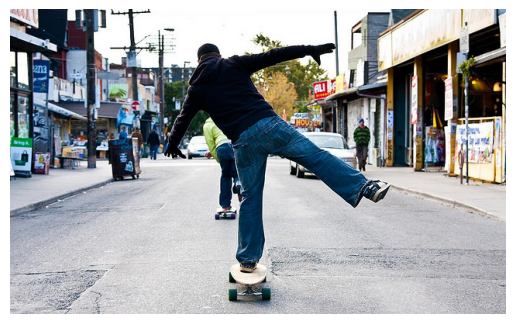

Generated: A man riding a skateboard down a street.


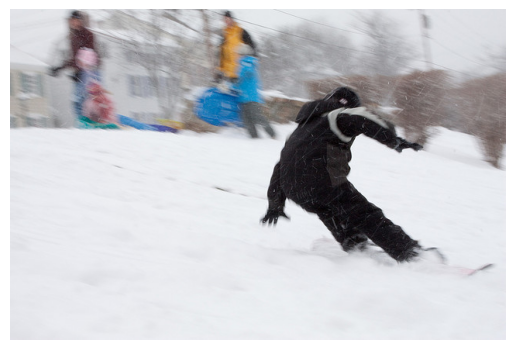

Generated: A man riding a snowboard down a snow covered slope.


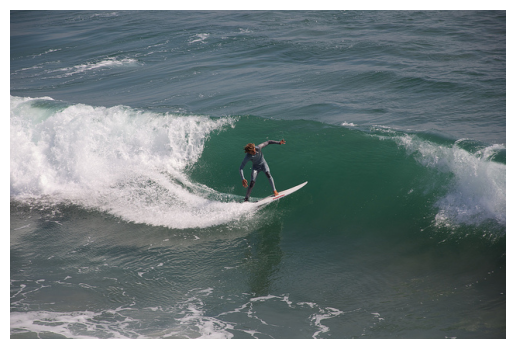

Generated: A surfer riding a wave on a surfboard.


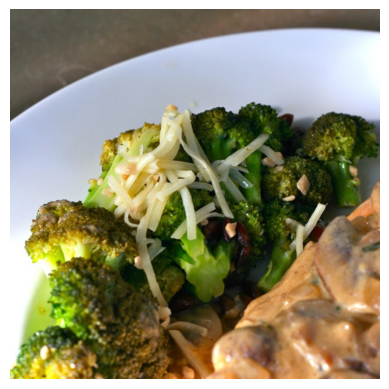

Generated: A plate of food with broccoli and meat.


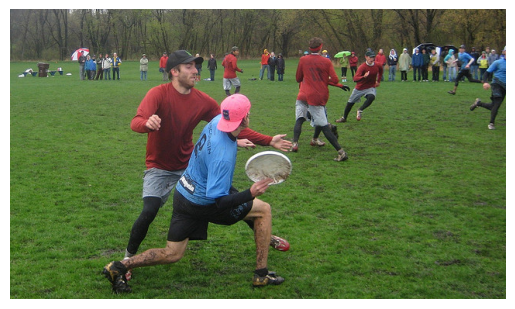

Generated: A man is throwing a frisbee in a park.


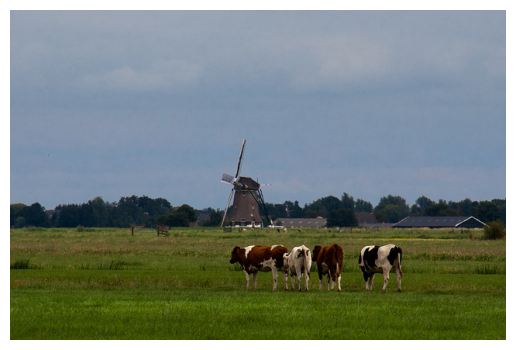

Generated: A herd of cows grazing in a field with a lighthouse in the background.


In [23]:
# image_paths = [
# '000000166391.jpg',
# '000000425702.jpg',
# '000000575815.jpg',
# '000000525322.jpg',
# '000000574520.jpg',
# '000000184324.jpg'
# ]

image_paths = [
'000000407116.jpg',
'000000100786.jpg',
'000000499739.jpg',
'000000337080.jpg',
'000000523525.jpg',
'000000534661.jpg'
]

display_images_with_generated_captions(trainer, image_paths)

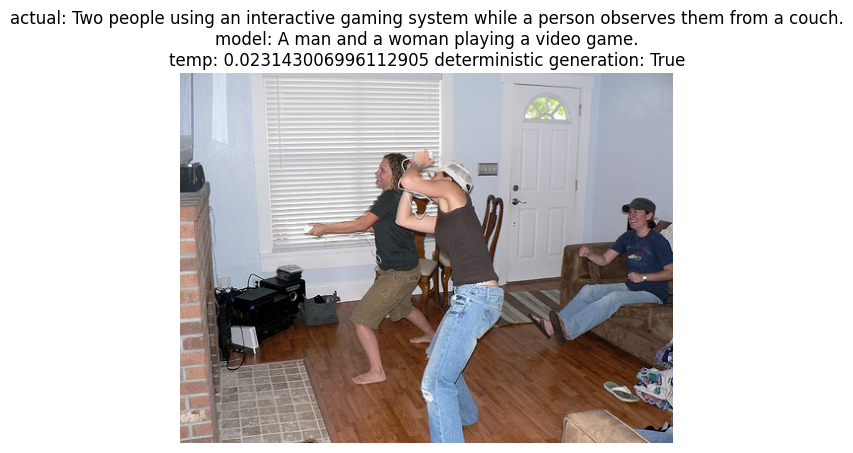

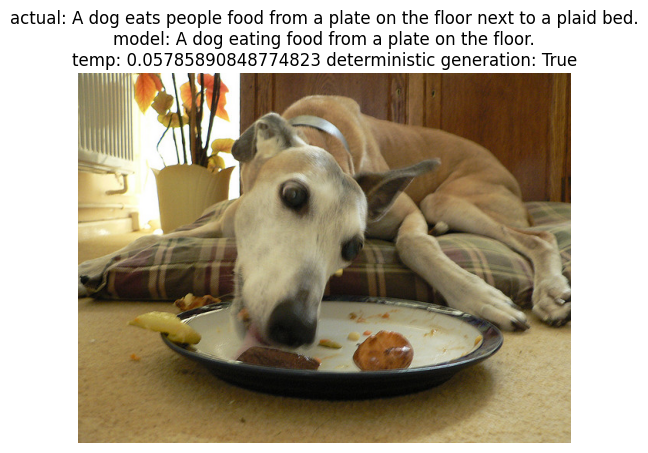

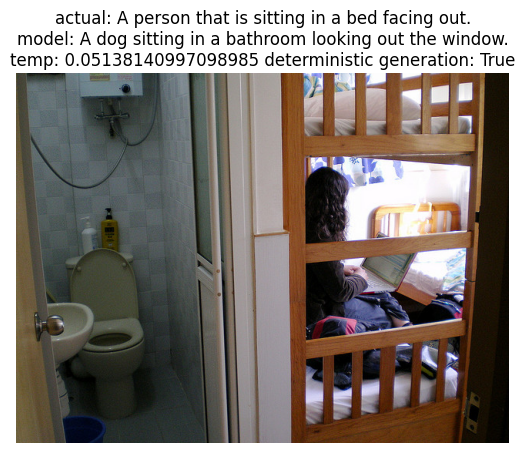

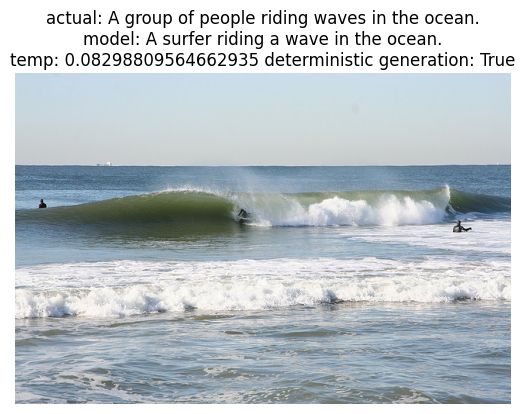

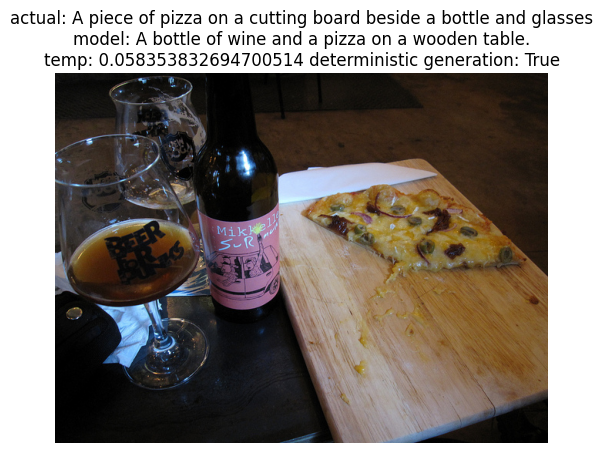

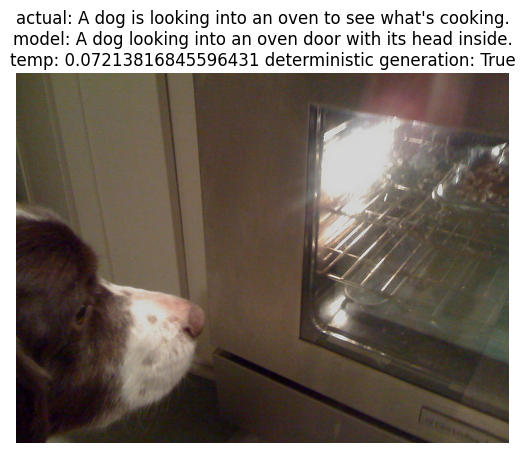

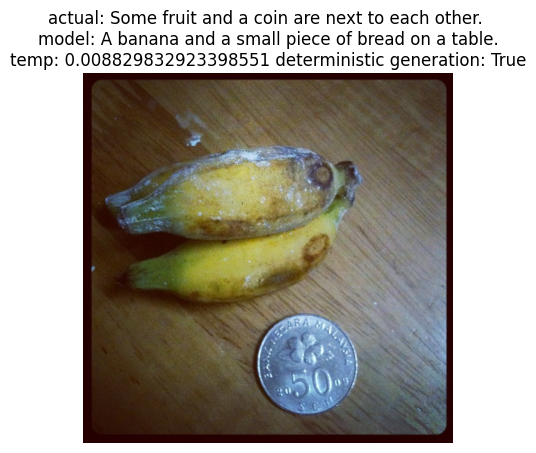

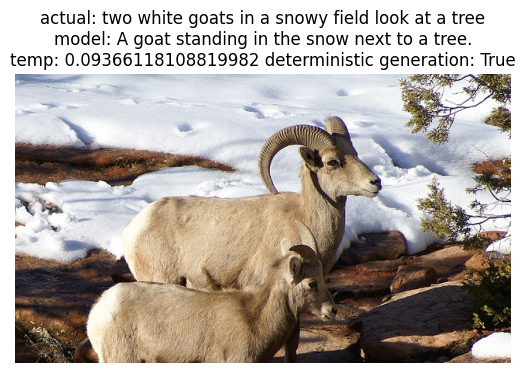

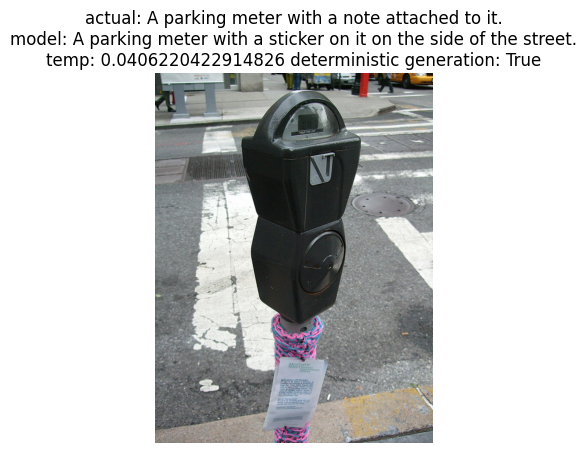

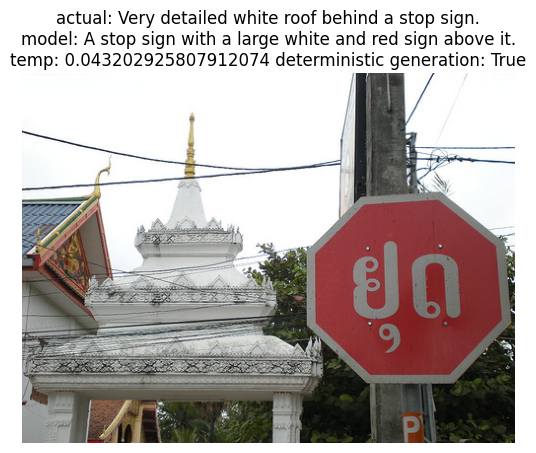

In [24]:
for i in range(10):
    det = True
    test = val_df.sample(n=1).values[0]
    test_img, test_caption = test[0],test[1]
    plt.imshow(Image.open(test_img).convert('RGB'))
    t = np.random.uniform(0,0.1)
    gen_caption = trainer.generate_caption(test_img,temperature=t,deterministic=det)
    plt.title(f"actual: {test_caption}\nmodel: {gen_caption}\ntemp: {t} deterministic generation: {det}")
    plt.axis('off')
    plt.show()

## Evaluation
---
To assess the performance of the image captioning models, we use the following metrics:

BLEU (Bilingual Evaluation Understudy): Measures how many n-grams in the generated caption overlap with the reference captions.
BLEU-1: Measures unigram precision. BLEU-2, BLEU-3, BLEU-4: Extend to bigrams, trigrams, and 4-grams, respectively.

METEOR (Metric for Evaluation of Translation with Explicit ORdering): Considers precision, recall, and alignment by matching words and phrases. It accounts for synonyms and stemming, making it more semantically aware.

ROUGE-L (Recall-Oriented Understudy for Gisting Evaluation): Focuses on the longest common subsequence (LCS) between the generated and reference captions, capturing sentence-level structure.

In [ ]:
def clean_and_tokenize(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  
    return word_tokenize(text.lower())

def generate_tokenized_captions(trainer, df):
    pred_result = []
    valid_result = []
    
    grouped_df = df.groupby('image')['caption'].apply(list).reset_index()
    
    print("Generating captions...")
    for _, row in tqdm(grouped_df.iterrows(), total=len(grouped_df), desc="Processing"):
        test_img = row['image']
        captions = row['caption']
        
        tokenized_captions = [clean_and_tokenize(caption) for caption in captions]
        valid_result.append(tokenized_captions)
        
        t = np.random.uniform(0, 0.1)
        gen_caption = trainer.generate_caption(test_img, temperature=t, deterministic=True)
        
        pred_result.append(clean_and_tokenize(gen_caption))
    
    return pred_result, valid_result


In [ ]:
pred_result, valid_result = generate_tokenized_captions(trainer, val_df)

In [ ]:
def preview_results(pred_result, valid_result, num_samples=5):
    for i, (pred, refs) in enumerate(zip(pred_result, valid_result)):
        if i >= num_samples:
            break
        print(f"Sample {i + 1}:")
        print(f"  Predicted: {' '.join(pred)}")
        print("  References:")
        for j, ref in enumerate(refs):
            print(f"    {j + 1}: {' '.join(ref)}")
        print()
        
preview_results(pred_result, valid_result, num_samples=5)

In [ ]:
def calculate_cider(predicted, references):
    def generate_ngrams(tokens, n):
        return [' '.join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

    cider_score = 0.0
    n = 4  # CIDEr typically uses up to 4-grams

    for k in range(1, n+1):
        pred_kgrams = generate_ngrams(predicted, k)
        ref_kgrams = [generate_ngrams(ref, k) for ref in references]
        
        pred_tf = Counter(pred_kgrams)
        ref_tf = Counter([gram for ref in ref_kgrams for gram in ref])

        def compute_tfidf(tf, doc_tf, n_docs):
            return {gram: tf[gram] * log(n_docs / (1 + doc_tf[gram])) for gram in tf}

        pred_tfidf = compute_tfidf(pred_tf, ref_tf, len(references))
        ref_tfidf = compute_tfidf(ref_tf, ref_tf, len(references))

        overlap = set(pred_tfidf.keys()) & set(ref_tfidf.keys())
        numerator = sum(pred_tfidf[gram] * ref_tfidf[gram] for gram in overlap)
        denominator = sqrt(sum(v**2 for v in pred_tfidf.values())) * \
                      sqrt(sum(v**2 for v in ref_tfidf.values()))

        cider_score += numerator / denominator if denominator > 0 else 0.0

    return cider_score / n

def calculate_rouge_l(predicted, references):
    def lcs_length(x, y):
        dp = [[0] * (len(y) + 1) for _ in range(len(x) + 1)]
        for i in range(1, len(x) + 1):
            for j in range(1, len(y) + 1):
                if x[i-1] == y[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        return dp[-1][-1]

    rouge_l_scores = []
    for ref in references:
        lcs = lcs_length(predicted, ref)
        precision = lcs / len(predicted) if len(predicted) > 0 else 0
        recall = lcs / len(ref) if len(ref) > 0 else 0
        if precision + recall > 0:
            f1 = (2 * precision * recall) / (precision + recall)
        else:
            f1 = 0
        rouge_l_scores.append(f1)

    return max(rouge_l_scores)  # Use the best matching reference

def evaluate(pred_result, valid_result):
    smoothing_function = SmoothingFunction().method1
    bleu_scores = {'BLEU-1': [], 'BLEU-2': [], 'BLEU-3': [], 'BLEU-4': []}
    cider_scores = []
    meteor_scores = []
    rouge_l_scores = []

    for pred, refs in zip(pred_result, valid_result):
        bleu_scores['BLEU-1'].append(sentence_bleu(refs, pred, weights=(1, 0, 0, 0), smoothing_function=smoothing_function))
        bleu_scores['BLEU-2'].append(sentence_bleu(refs, pred, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function))
        bleu_scores['BLEU-3'].append(sentence_bleu(refs, pred, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function))
        bleu_scores['BLEU-4'].append(sentence_bleu(refs, pred, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function))

        cider_scores.append(calculate_cider(pred, refs))
        meteor_scores.append(meteor_score([' '.join(ref) for ref in refs], ' '.join(pred)))
        rouge_l_scores.append(calculate_rouge_l(pred, refs))

    avg_scores = {
        'BLEU-1': np.mean(bleu_scores['BLEU-1']),
        'BLEU-2': np.mean(bleu_scores['BLEU-2']),
        'BLEU-3': np.mean(bleu_scores['BLEU-3']),
        'BLEU-4': np.mean(bleu_scores['BLEU-4']),
        'CIDEr': np.mean(cider_scores),
        'METEOR': np.mean(meteor_scores),
        'ROUGE-L': np.mean(rouge_l_scores)
    }

    return avg_scores


In [ ]:
scores = evaluate(pred_result, valid_result)
print("Evaluation Scores:", scores)

## Save Config
---

In [ ]:
def save_model_as_torchscript(model, save_path):
    model.eval()
    
    image_size = torch.rand(1, 3, 224, 224)
    input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.seq_len))
    
    traced_script_module = torch.jit.trace(model, (image_size, input_ids))
    
    traced_script_module.save(save_path)
    print(f"Model saved as TorchScript to {save_path}")


model = VisionGPT2Model.from_pretrained(model_config)

model.load_state_dict(torch.load('/kaggle/input/vit-gpt-result/captioner (3).pt'))
save_model_as_torchscript(model, "vision_gpt2_model.pt")

In [ ]:
def load_torchscript_model(load_path):
    loaded_model = torch.jit.load(load_path)
    print(f"Model loaded from {load_path}")
    return loaded_model

loaded_model = load_torchscript_model("vision_gpt2_model.pt")